In [ ]:
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt 
from sklearn.utils import shuffle
import numpy as np
import statistics
import math

In [ ]:
import load_data as ld
(train_data , train_labels , validation_data , validation_labels , test_data , test_labels) = ld.load()

In [ ]:
class FeedForwardNeuralNetwork():

###################################################### Constructor ################################################################

  def __init__(self, input_dim, output_dim, hidden_dim, hidden_layers, activation = "sigmoid", weight_intialisation = "random"):
    np.random.seed(1234)
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.hidden_layers = hidden_layers
    self.L = hidden_layers
    self.activation = activation
    self.weight_initialisation = weight_initialisation
    self.initialize()


##################################### Function for storing dimensions of all the layers ############################################

  def size(self):
    l_sizes = []
    l_sizes.append(self.input_dim)
    for m in range(self.hidden_layers):
      l_sizes.append(self.hidden_dim)
    l_sizes.append(self.output_dim)
    return l_sizes


######################################## Function for initialization ###########################################3

  def initialize(self):
    size = self.size()    

#-------------------------- random weight-initialization ---------------------------------

    if self.weight_initialisation == "random":
      self.Weights=[np.random.randn(size[i + 1], size[i]) for i in range(len(size) - 1)]   

#--------------------------- xavier weight-initialization --------------------------------

    if self.weight_initialisation == "xavier":
      self.Weights=[np.random.randn(size[i + 1], size[i])*np.sqrt(2/(size[i]+size[i+1])) for i in range(len(size) - 1)]

#--------------Initialize Biases, Activation, Preactivation, update weights and update biases ndarray  ----------------------

    self.Update_Weights=[np.zeros((size[i + 1], size[i])) for i in range(len(size) - 1)]
    self.Biases= [np.zeros((size[i + 1], 1)) for i in range(len(size) - 1)]
    self.Update_Biases= [np.zeros((size[i + 1], 1)) for i in range(len(size) - 1)]
    self.A = [np.zeros((size[i + 1], 1)) for i in range(len(size) - 1)]
    self.H = [np.zeros((size[i + 1], 1)) for i in range(len(size) - 1)]
  
 ######################################### Activation Function ####################################################################
  
  def activation_function(self, x, activation = "sigmoid"):
    if activation == "sigmoid":
      return np.where(x >= 0, 1 / (1 + np.exp(-x)),np.exp(x) / (1 + np.exp(x)))

    if activation == "tanh":
      return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    if activation == "relu":
      # return np.where(x>=0,x,0)
      return np.where(x>=0,0.12*x,0)


    if activation == "lrelu":
      return np.where(x>0,x,0.2*x)
      # temp = np.where(x>0,x,0)
      # print("temp in relu : ",temp)
      # return np.where(x>0,x,0)


 ######################################### Function for finding derivative of activation  ######################################

  def diff_activation_function(self, x, activation = "sigmoid"):
    if activation == "sigmoid":
      fx = np.where(x >= 0, 1 / (1 + np.exp(-x)),np.exp(x) / (1 + np.exp(x)))
      return fx * (1 - fx)

    if activation == "tanh":
      fx = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
      return (1 - np.power((fx),2))

    if activation == "relu":
      return np.where(x>=0,0.12,0) 

    if activation == "lrelu":
      return np.where(x>=0,1,0.2)

    return


######################################### Prectivation Function ###################################################


  def preactivation(self, w, h_prev, b):
    return (np.dot(w,h_prev) + b)

##################################### Output Function using stable Softmax #####################################################


  def output_function(self, x): 
    z=x-x.max()
    num=np.exp(z)
    denom=np.sum(num,axis=0)
    return num/denom

######################################### converting label to corresponding one hot vector  ###################################################

  def oneHot(self, num, size = 10):
    vec = [0]*size
    # print("num :",num)
    vec[num] = 1
    vec = np.array(vec)
    vec = vec.reshape(len(vec),1)
    return vec


######################################### Calculate accuracy and losses of our model  ###################################################

  def calculate_accuracy(self, test_data, test_labels, limit):
    predictions = []
    count = 0
    for example in test_data[:limit]:
      predictions.append(self.forwardPropagation(example.reshape(784,1)))
    predicted_labels = list(map(np.argmax, predictions))
    for p,l in zip(predicted_labels, test_labels[:limit]):
      if p == l:
        count += 1
    # print("accuracy% : ", (count/len(test_data))*100)
    return (count/limit)*100

#--------------------------- cross entropy loss --------------------------------

  def ce_loss(self, data, labels, limit):
    predictions = []
    count = 0
    for example in data[:limit]:
      predictions.append(self.forwardPropagation(example.reshape(784,1)))
    #-log(predictions[labels[i]])
    total_ce_loss = 0
    for i in range(limit):
      total_ce_loss += -math.log(predictions[i][labels[i]])
    average_ce_loss = total_ce_loss / limit
    return average_ce_loss

#--------------------------- squared_error_loss --------------------------------

  def squared_error_loss(self, data, labels, limit):
    predictions = []
    count = 0
    for example in data[:limit]:
      predictions.append(self.forwardPropagation(example.reshape(784,1)))
    #
    total_sqe_loss = 0
    for i in range(limit):
      total_sqe_loss += sum(np.power(self.oneHot(labels[i])-predictions[i],2))
    average_sqe_loss = total_sqe_loss[0] / limit
    return average_sqe_loss


######################################### function for Forward propogation  ###################################################


  def forwardPropagation(self, input_vector):
    activation = self.activation
    L = self.L   #total layers - input layer
    self.A[0] = self.Biases[0] + np.dot(self.Weights[0], input_vector)
    self.H[0] = self.activation_function(self.A[0], activation)

    for k in range(1,L):
      self.A[k] = np.array(self.preactivation(self.Weights[k], self.H[k-1], self.Biases[k]))
      self.H[k] = self.activation_function(self.A[k], activation)

    self.A[L] = np.array(self.preactivation(self.Weights[L], self.H[L-1], self.Biases[L]))
    self.H[L] = self.output_function(self.A[L])

    return self.H[L] #H[L] = y^




######################################### function for back propogation  ###################################################


  def backPropagation(self, train_data,truelabel,prediction, loss_type):
    
    L = self.L
    grad_Weights = [0]*(L+1)
    grad_Biases = [0]*(L+1)
    activation = self.activation
    
    a = None
    if loss_type == "sqe":
      a = np.power(self.oneHot(truelabel)-prediction,2)

    if loss_type == "ce":     
      e = np.zeros((10,1))
      e[truelabel] = 1      
      # a = -(e - self.H[L])
      a = -(e - prediction)

    for k in range(L, -1, -1):
      if k==0:
        grad_Weights[k] = a.dot((train_data).T)
      else:
        grad_Weights[k] = a.dot((self.H[k-1]).T)

      grad_Biases[k] = a
      if k!=0:
        second = self.diff_activation_function(self.A[k-1], activation)
        first = (self.Weights[k].T).dot(a)
        a =  np.multiply(first,second)
    

    return (grad_Weights,grad_Biases)

######################################### Training of our model  ###################################################

  def trainingAlgo(self, opt = 'adam', gamma = 0.9, eta = 1e-4, batch_size = 1, max_epochs = 1,alpha = 0.1, eps = 1e-6, beta = 0.9, limit = 500, vlimit= 500, tlimit = 500, loss_type = "ce"):

    (train_data , train_labels , validation_data , validation_labels , test_data , test_labels) = ld.load()

    N = train_data.shape[0]
    L = self.L
    loss = []    

    if opt=='adam' or 'nadam':
      m_w,m_b = [0]*(L+1),[0]*(L+1)
      step = 1

    for i in range(max_epochs):
      print("\nEpoch : ", i+1)
      g_w, g_b = [0]*(L+1), [0]*(L+1)
      count = 0
      X_train,y_train = shuffle(train_data,train_labels,random_state=0)
      # for x, y in zip(X_train, y_train):
      for x, y in zip(X_train[:limit], y_train[:limit]):
        # print("\ntraining for example number : ", count+1)

        predictions=self.forwardPropagation(x.reshape(784,1))
        (grad_Weights, grad_Biases) = self.backPropagation(x.reshape(784,1),y,predictions, loss_type)

        for j in range(L+1):
          g_w[j] = g_w[j] + grad_Weights[j]
          g_b[j] = g_b[j] + grad_Biases[j]
        count = count + 1

        if count % batch_size == 0 or count == N :

#-----------------------------update weights and biases for momentum based stochastic gradient descent optimizer-----------------------------------------
          if opt=='momentum':
            for j in range(0,L+1):
              self.Update_Weights[j] = gamma * self.Update_Weights[j] + (eta * grad_Weights[j])
              self.Weights[j] =self.Weights[j]-self.Update_Weights[j]

              self.Update_Biases[j] = gamma * self.Update_Biases[j] + (eta * grad_Biases[j])
              self.Biases[j]  = self.Biases[j] - self.Update_Biases[j]



#-----------------------------update weights and biases for Stochastic gradient descent optimizer-----------------------------------------
          elif opt=='sgd':
            for j in range(L + 1):
              self.Weights[j]   = self.Weights[j]-(eta*grad_Weights[j])
              self.Biases[j]  = self.Biases[j]-(eta * grad_Biases[j])



#-----------------------------update weights and biases for nestrov optimizer-----------------------------------------
          elif opt=='nestrov':
            for j in range(L + 1):
              self.Update_Weights[j] = (gamma * self.Update_Weights[j]) + (eta * g_w[j])
              self.Weights[j]  = self.Weights[j] - ( gamma * prev_w[j] + eta * g_w[j] )

              self.Update_Biases[j] = (gamma *  self.Update_Biases[j]) + (eta * g_b[j])
              self.Biases[j]  = self.Biases[j]- ( gamma *  self.Update_Biases[j] + eta * g_b[j] )



#-----------------------------update weights and biases for RMSProp optimizer-----------------------------------------
          elif opt=='rmsprop':
            for j in range(L + 1):
              self.Update_Weights[j] = beta * self.Update_Weights[j] + (1 - beta) * g_w[j]**2
              self.Weights[j] = ( 1 - eta*alpha ) * self.Update_Weights[j] - eta /( np.sqrt(self.Update_Weights[j])+ eps) * grad_Weights[j]

              self.Update_Biases[j]= beta *  self.Update_Biases[j] + (1 - beta) * g_b[j]**2
              self.Biases[j]  = self.Biases[j] -(eta / (np.sqrt( self.Update_Biases[j]) +eps)) * grad_Biases[j]




#-----------------------------update weights and biases for Adam optimizer-----------------------------------------
          elif opt=='adam':
            # pass
            beta1 = 0.9
            beta2 = 0.999
            for j in range(L + 1):

              self.Update_Weights[j] = beta2 * self.Update_Weights[j] + (1 - beta2) * g_w[j]**2
              m_w[j]=beta1*m_w[j] +(1-beta1) * g_w[j]
              m_w_hat=m_w[j]/(1-math.pow(beta1,step))
              v_w_hat=self.Update_Weights[j]/(1-math.pow(beta2,step))
              self.Weights[j]=(1-eta*alpha/N)*self.Weights[j] -(eta/(np.sqrt(v_w_hat)+eps))*m_w_hat

              self.Update_Biases[j] = beta2 * self.Update_Biases[j] + (1 - beta2) * g_b[j]**2
              m_b[j]=beta1*m_b[j] +(1-beta1) * g_b[j]
              m_b_hat=m_b[j]/(1-math.pow(beta1,step))
              v_b_hat=self.Update_Biases[j]/(1-math.pow(beta2,step))
              self.Biases[j] = self.Biases[j] -(eta / (np.sqrt(v_b_hat)+eps))* m_b_hat



#-----------------------------updating weights and biases for Nadam optimizer-----------------------------------------
          elif opt=='nadam':
            # pass
            beta1 = 0.9
            beta2 = 0.999
            for j in range(L + 1):
              self.Update_Weights[j] = beta2 * self.Update_Weights[j] + (1 - beta2) * g_w[j] ** 2
              m_w[j] = beta1 * m_w[j] + (1 - beta1) * g_w[j]
              m_w_hat = m_w[j] / (1 - math.pow(beta1, step))
              m_w_hat = beta1 * m_w_hat + ((1 - beta1) * g_w[j]) / (1 - math.pow(beta1, step))
              v_w_hat=self.Update_Weights[j]/(1-math.pow(beta2,step))
              self.Weights[j] = (1 - eta * alpha) * self.Weights[j] -(eta /( np.sqrt(v_w_hat) + eps)) * m_w_hat

              self.Update_Biases[j] = beta2 * self.Update_Biases[j] + (1 - beta2) * g_b[j] ** 2
              m_b[j] = beta1 * m_b[j] + (1 - beta1) * g_b[j]
              m_b_hat = beta1 * (m_b[j] / (1 - math.pow(beta1, step))) + ((1 - beta1) * g_b[j]) / (1 - math.pow(beta1, step))
              v_b_hat=self.Update_Biases[j]/(1-math.pow(beta2,step))
              self.Biases[j] = self.Biases[j]-(eta/(np.sqrt(v_b_hat)+eps))*m_b_hat

          else:
            pass

          g_w=[0]*(L+1)
          g_b=[0]*(L+1)
          step = step + 1
      train_acc = self.calculate_accuracy(train_data, train_labels, limit)
      val_acc = self.calculate_accuracy(validation_data, validation_labels, vlimit)
      test_acc = self.calculate_accuracy(test_data, test_labels, tlimit)

      # 8Q ans)
      if loss_type == "ce":
        train_ce_loss = self.ce_loss(train_data, train_labels, limit)
        valid_ce_loss = self.ce_loss(validation_data, validation_labels, vlimit)
        test_ce_loss = self.ce_loss(test_data, test_labels, tlimit)
        loss.append(test_ce_loss)
      if loss_type == "sqe":
        test_sqe_loss = self.squared_error_loss(test_data, test_labels, tlimit)
        loss.append(test_sqe_loss)
     

    return loss

  #============================================================================================================================================================================================================================================


In [ ]:
number_of_hidden_layers = 1
number_of_neurons_in_hidden_layer = 128
activation_function = "sigmoid"
weight_initialisation = "xavier"
optimiser = "adam"
gamma = 0.9
eta = 1e-4
batch_size = 1
max_epochs = 1
alpha = 0.005
train_limit = len(train_data)
test_limit = len(test_data)
validation_limit = len(validation_data)

In [ ]:
#===========================================================================Run without WandB ====================================================================================================


number_of_hidden_layers = 4
number_of_neurons_in_hidden_layer = 128
activation_function = "tanh"
weight_initialisation = "xavier"
optimiser = "adam"
gamma = 0.9
eta = 1e-3
batch_size = 64
max_epochs = 10
alpha = 0.5
loss_type = "ce" # sqe
train_limit = len(train_data)
test_limit = len(test_data)
validation_limit = len(validation_data)
# train_limit = 500
# test_limit = 500
# validation_limit = 500

ffnn1 = FeedForwardNeuralNetwork(784, 10, number_of_neurons_in_hidden_layer, number_of_hidden_layers, activation_function, weight_initialisation)
loss1 = ffnn1.trainingAlgo(optimiser, gamma, eta, batch_size, max_epochs, alpha, limit = train_limit, vlimit = validation_limit, tlimit = test_limit, loss_type = "ce")
print("==================================================================================================================================================================================================")
ffnn2 = FeedForwardNeuralNetwork(784, 10, number_of_neurons_in_hidden_layer, number_of_hidden_layers, activation_function, weight_initialisation)
loss2 = ffnn2.trainingAlgo(optimiser, gamma, eta, batch_size, max_epochs, alpha, limit = train_limit, vlimit = validation_limit, tlimit = test_limit, loss_type = "sqe")

In [14]:
print("cross_entropy loss: ",loss1)
print("==========================================================================================")
print("square error loss : ",loss2)

cross_entropy loss:  [0.4363928285676967, 0.4024874005725422, 0.3678191201017786, 0.36184962400836473, 0.3693317687361954, 0.3734739970089634, 0.3919448044911578, 0.3777499754588874, 0.38155280911819184, 0.377931755364064]
square error loss :  [1.2727956927413053, 1.280001340214756, 1.2865072438889784, 1.290270044017152, 1.2961659445478908, 1.2979260313382794, 1.2977162217409872, 1.3002190898429828, 1.3047412477591056, 1.3035950728161627]


In [ ]:
import matplotlib.pyplot as plt

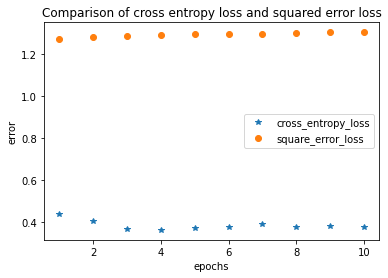

In [ ]:
X = list(range(1,len(loss1)+1))
# a = plt.scatter(X,loss1)
# plt.plot(a, X, loss1)
# plt.show()
plt.plot(X, loss1, '*', label='cross_entropy_loss')
plt.plot(X, loss2, 'o', label='square_error_loss')
plt.legend(loc='best')
plt.title('Comparison of cross entropy loss and squared error loss')
plt.ylabel('error')
plt.xlabel('epochs')
plt.show()